# DATA

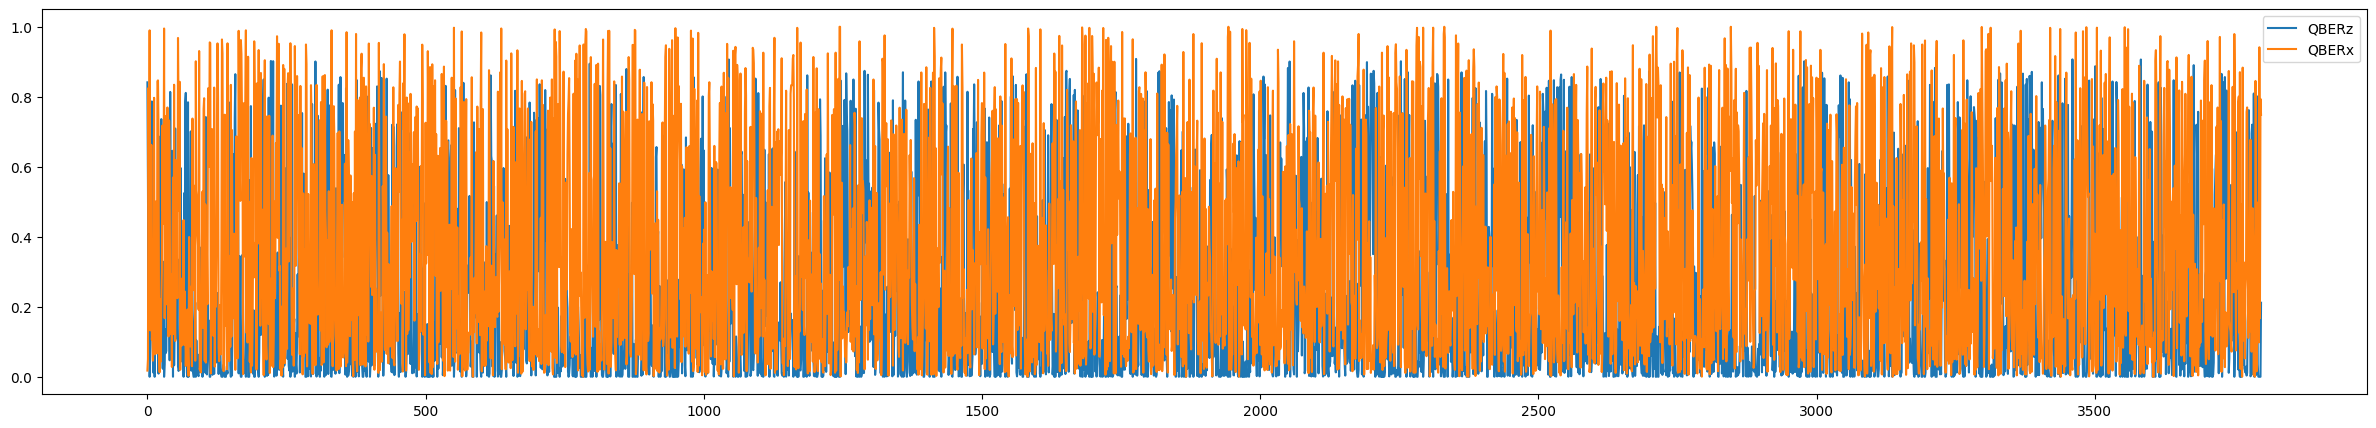

In [1]:
from matplotlib import pyplot as plt
from environment.models.weather_control_fixed import WeatherControlledFixedEnv

env = WeatherControlledFixedEnv(fibre_segments=3)

env.max_steps = 3800
env.reset()
while not env.done:
    env.step()

QBERS = env.get_qber()
plt.figure(figsize=(30, 5))
plt.plot(QBERS)
plt.legend(['QBERz', 'QBERx'])
plt.show()

In [2]:
from data.utils.data_processing import load_historical_weather_data
weather_data = load_historical_weather_data()
n = len(weather_data) - len(QBERS)
weather_data = weather_data.iloc[:-n]

# Check if the length of the weather data and QBER data match
if not len(weather_data) == len(QBERS):
    raise ValueError("Length of weather data and QBER data do not match")

# SARIMA

In [3]:
# grid search ARIMA parameters for time series
import warnings
from math import sqrt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import numpy as np

In [4]:
# # evaluate an ARIMA model for a given order (p,d,q)
# def evaluate_arima_model(X, arima_order):
#     # prepare training dataset
#     train_size = int(len(X) * 0.66)
#     train, test = X[0:train_size], X[train_size:]
#     history = [x for x in train]
#     # make predictions
#     predictions = list()
#     for t in range(len(test)):
#         model = ARIMA(history, order=arima_order)
#         model_fit = model.fit()
#         yhat = model_fit.forecast()[0]
#         predictions.append(yhat)
#         history.append(test[t])
#     # calculate out of sample error
#     rmse = sqrt(mean_squared_error(test, predictions))
#     return rmse
 
# # evaluate combinations of p, d and q values for an ARIMA model
# def evaluate_models(dataset, p_values, d_values, q_values):
#     dataset = dataset.astype('float32')
#     best_score, best_cfg = float("inf"), None
#     for p in p_values:
#         for d in d_values:
#             for q in q_values:
#                 order = (p,d,q)
#                 try:
#                     rmse = evaluate_arima_model(dataset, order)
#                     if rmse < best_score:
#                         best_score, best_cfg = rmse, order
#                     print('ARIMA%s RMSE=%.3f' % (order,rmse))
#                 except:
#                     continue
#     print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))
 
# # load dataset
# # def parser(x):
# #     return datetime.strptime('190'+x, '%Y-%m')
# # series = read_csv('shampoo-sales.csv', header=0, index_col=0, parse_dates=True, squeeze=True, date_parser=parser)
# # evaluate parameters
# p_values = [0, 1, 2, 4, 6, 8, 10]
# d_values = range(0, 3)
# q_values = range(0, 3)
# warnings.filterwarnings("ignore")
# evaluate_models(np.array(QBERS[:,0]), p_values, d_values, q_values)


In [ ]:
from tqdm import tqdm

X = QBERS[:,0]
# prepare training dataset
train_size = int(len(X) * 0.66)
train, test = X[0:train_size], X[train_size:]
history = [x for x in train]
# make predictions
predictions = list()
for t in tqdm(range(len(test))):
    model = ARIMA(history, order= (1,2,0))
    model_fit = model.fit()
    yhat = model_fit.forecast()[0]
    predictions.append(yhat)
    history.append(test[t])
# calculate out of sample error
rmse = sqrt(mean_squared_error(test, predictions))

 19%|█▉        | 249/1292 [00:19<01:25, 12.23it/s]/usr/local/lib/python3.8/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
100%|██████████| 1292/1292 [01:31<00:00, 14.14it/s]


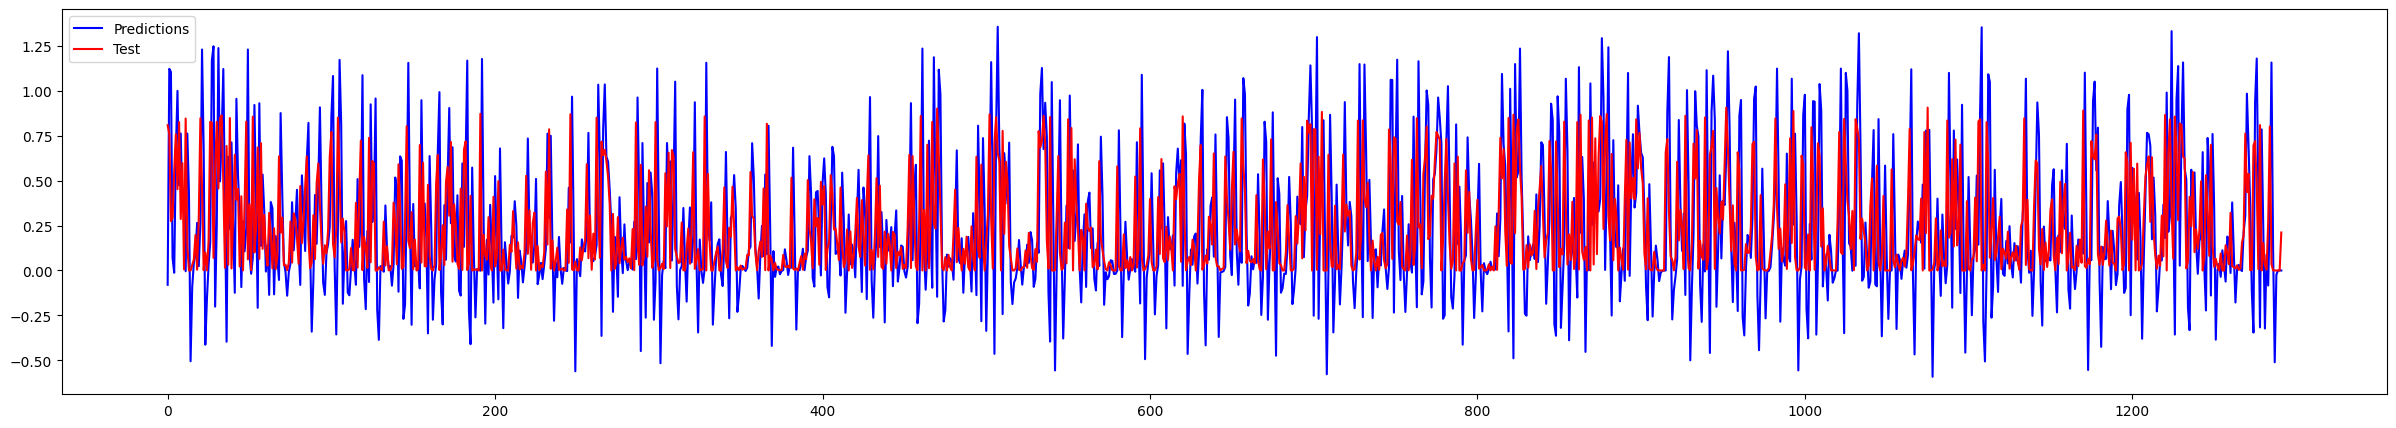

In [ ]:
plt.figure(figsize=(30, 5))
plt.plot(predictions, 'b')
plt.plot(test, 'r')
plt.legend(['Predictions', 'Test'])

# Forces

In [11]:
from tqdm import tqdm

# print(env.Fs[0])
X = env.Fs[0]
# prepare training dataset
train_size = int(len(X) * 0.66)
train, test = X[0:train_size], X[train_size:]
history = [x for x in train]
# make predictions
predictions = list()
for t in tqdm(range(len(test))):
    model = ARIMA(history, order= (1,2,0))
    model_fit = model.fit()
    yhat = model_fit.forecast()[0]
    predictions.append(yhat)
    history.append(test[t])
# calculate out of sample error
rmse = sqrt(mean_squared_error(test, predictions))

100%|██████████| 1292/1292 [00:55<00:00, 23.10it/s]


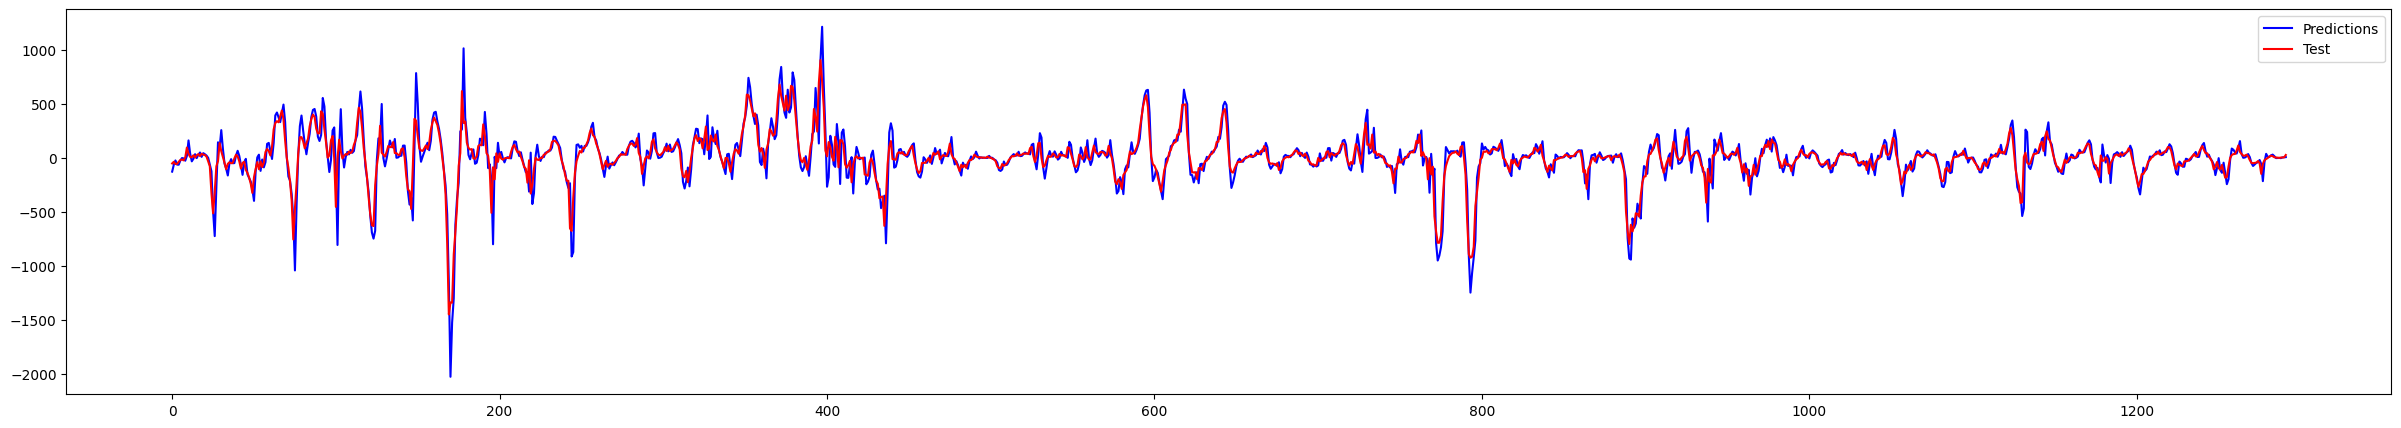

In [13]:
plt.figure(figsize=(30, 5))
plt.plot(predictions, 'b')
plt.plot(test, 'r')
plt.legend(['Predictions', 'Test'])

# FFT SARIMA

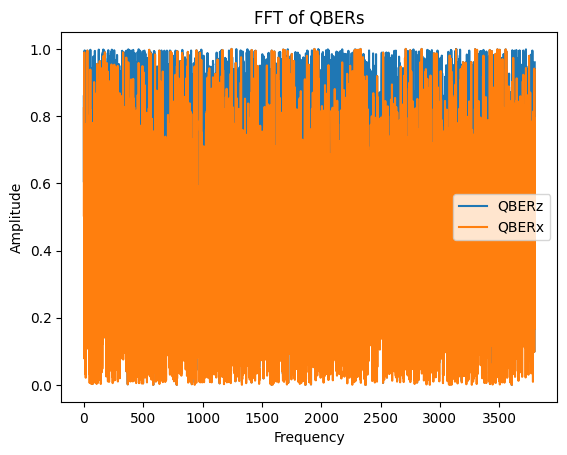

In [35]:
QBER_fft = np.fft.rfft(QBERS[:,:])
z_fft = QBER_fft[:,0]
x_fft = QBER_fft[:,1]

plt.plot(np.abs(z_fft))
plt.plot(np.abs(x_fft))
plt.xlabel('Frequency')
plt.ylabel('Amplitude')
plt.title('FFT of QBERs')
plt.legend(['QBERz', 'QBERx'])
plt.show()

In [80]:
# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order):
    # prepare training dataset
    train_size = int(len(X) * 0.66)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit()
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    # calculate out of sample error
    rmse = sqrt(mean_squared_error(test, predictions))
    return rmse
 
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    rmse = evaluate_arima_model(dataset, order)
                    if rmse < best_score:
                        best_score, best_cfg = rmse, order
                    print('ARIMA%s RMSE=%.3f' % (order,rmse))
                except:
                    continue
    print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))
 
# load dataset
# def parser(x):
#     return datetime.strptime('190'+x, '%Y-%m')
# series = read_csv('shampoo-sales.csv', header=0, index_col=0, parse_dates=True, squeeze=True, date_parser=parser)
# evaluate parameters
p_values = [0, 1, 2, 4, 6, 8, 10]
d_values = range(0, 3)
q_values = range(0, 3)
warnings.filterwarnings("ignore")
evaluate_models(np.array(QBER_fft[:,0]), p_values, d_values, q_values)


ARIMA(0, 0, 0) RMSE=0.308
ARIMA(0, 0, 1) RMSE=0.308
ARIMA(0, 0, 2) RMSE=0.307
ARIMA(0, 1, 0) RMSE=0.430
ARIMA(0, 1, 1) RMSE=0.308
ARIMA(0, 1, 2) RMSE=0.308
ARIMA(0, 2, 0) RMSE=0.749
ARIMA(0, 2, 1) RMSE=0.430
ARIMA(0, 2, 2) RMSE=0.309
ARIMA(1, 0, 0) RMSE=0.308
ARIMA(1, 0, 1) RMSE=0.308
ARIMA(1, 0, 2) RMSE=0.307
ARIMA(1, 1, 0) RMSE=0.368
ARIMA(1, 1, 1) RMSE=0.308
ARIMA(1, 1, 2) RMSE=0.308
ARIMA(1, 2, 0) RMSE=0.549
ARIMA(1, 2, 1) RMSE=0.368
ARIMA(1, 2, 2) RMSE=0.310
ARIMA(2, 0, 0) RMSE=0.307
ARIMA(2, 0, 1) RMSE=0.308
ARIMA(2, 0, 2) RMSE=0.307
ARIMA(2, 1, 0) RMSE=0.348
ARIMA(2, 1, 1) RMSE=0.307
ARIMA(2, 1, 2) RMSE=130.031
ARIMA(2, 2, 0) RMSE=0.471


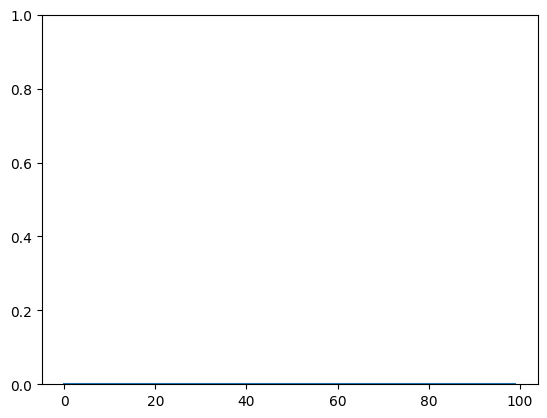

In [46]:
inverse_predictions = np.fft.irfft(QBER_fft)
plt.ylim(0, 1)
plt.plot((inverse_predictions[:100, 0] - QBERS[:100, 0])**2)

In [66]:
from tqdm import tqdm

# print(env.Fs[0])
X = np.abs(QBER_fft[:,0])
# prepare training dataset
train_size = int(len(X) * 0.66)
train, test = X[0:train_size], X[train_size:]
history = [x for x in train]
# make predictions
predictions = list()
for t in tqdm(range(len(test))):
    model = ARIMA(history, order= (1,2,0))
    model_fit = model.fit()
    yhat = model_fit.forecast()[0]
    predictions.append(yhat)
    history.append(test[t])
# calculate out of sample error
rmse = sqrt(mean_squared_error(test, predictions))

100%|██████████| 1292/1292 [00:46<00:00, 27.58it/s]


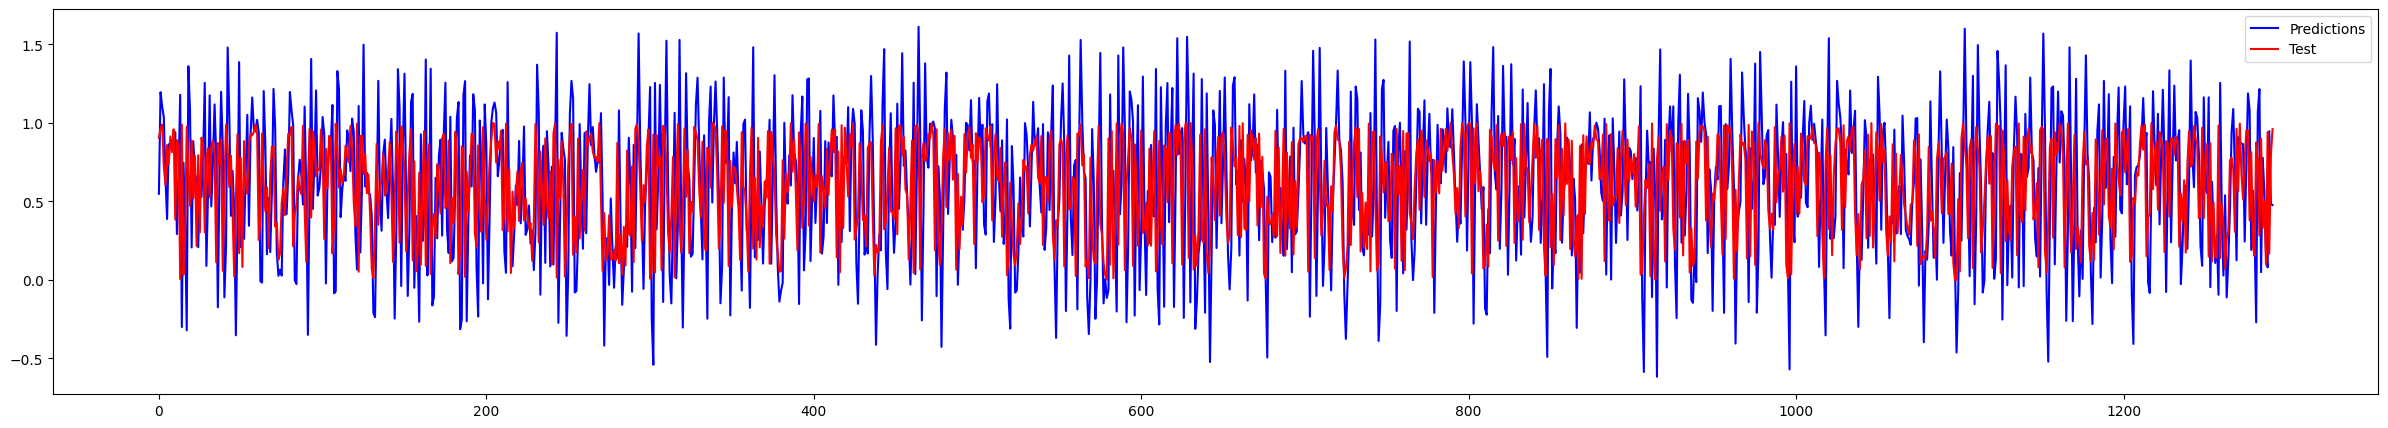

In [67]:
plt.figure(figsize=(30, 5))
plt.plot(predictions, 'b')
plt.plot(test, 'r')
plt.legend(['Predictions', 'Test'])

In [68]:
from tqdm import tqdm

# print(env.Fs[0])
X = np.abs(QBER_fft[:,1])
# prepare training dataset
train_size = int(len(X) * 0.66)
train, test = X[0:train_size], X[train_size:]
history = [x for x in train]
# make predictions
predictions2 = list()
for t in tqdm(range(len(test))):
    model = ARIMA(history, order= (1,2,0))
    model_fit = model.fit()
    yhat = model_fit.forecast()[0]
    predictions2.append(yhat)
    history.append(test[t])

100%|██████████| 1292/1292 [00:54<00:00, 23.88it/s]


In [69]:
# calculate out of sample error
rmse = sqrt(mean_squared_error(test, predictions2))

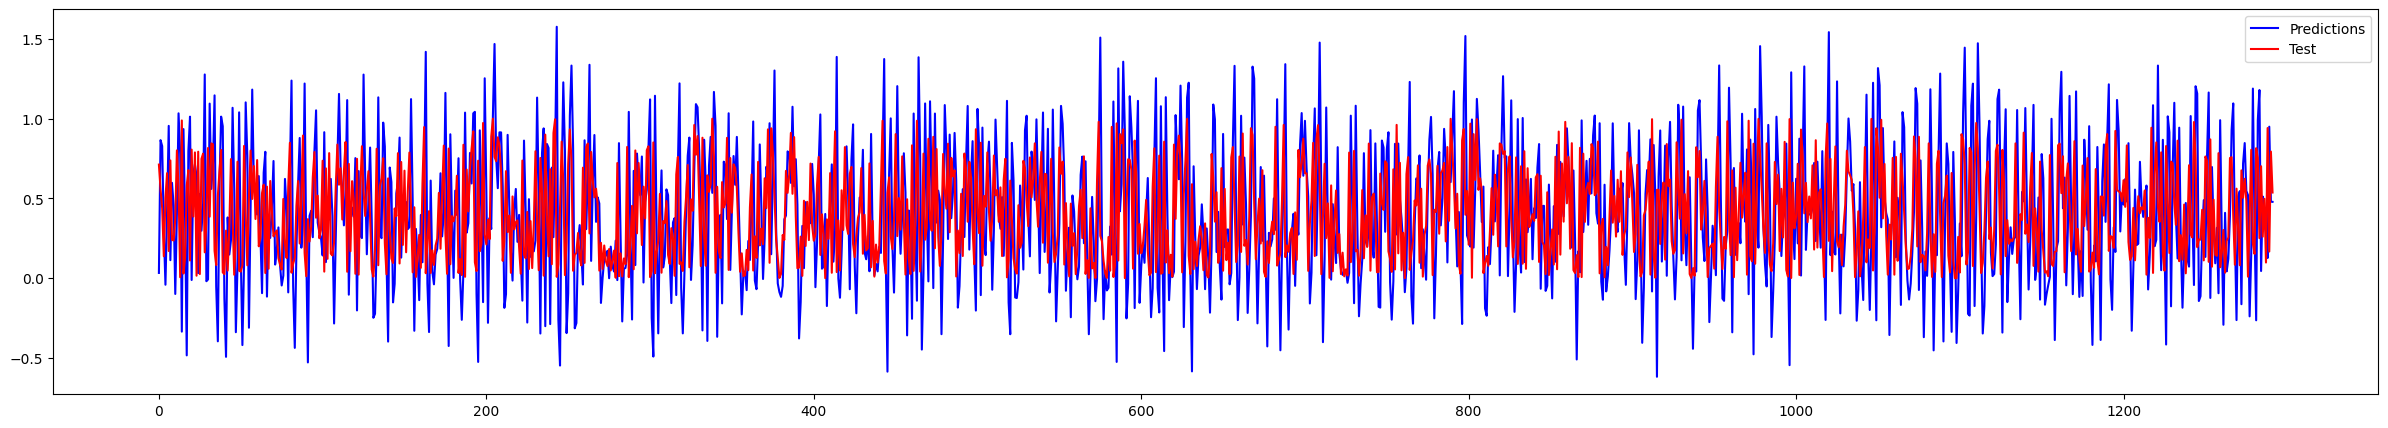

In [70]:
plt.figure(figsize=(30, 5))
plt.plot(predictions2, 'b')
plt.plot(test, 'r')
plt.legend(['Predictions', 'Test'])

(1292, 2)


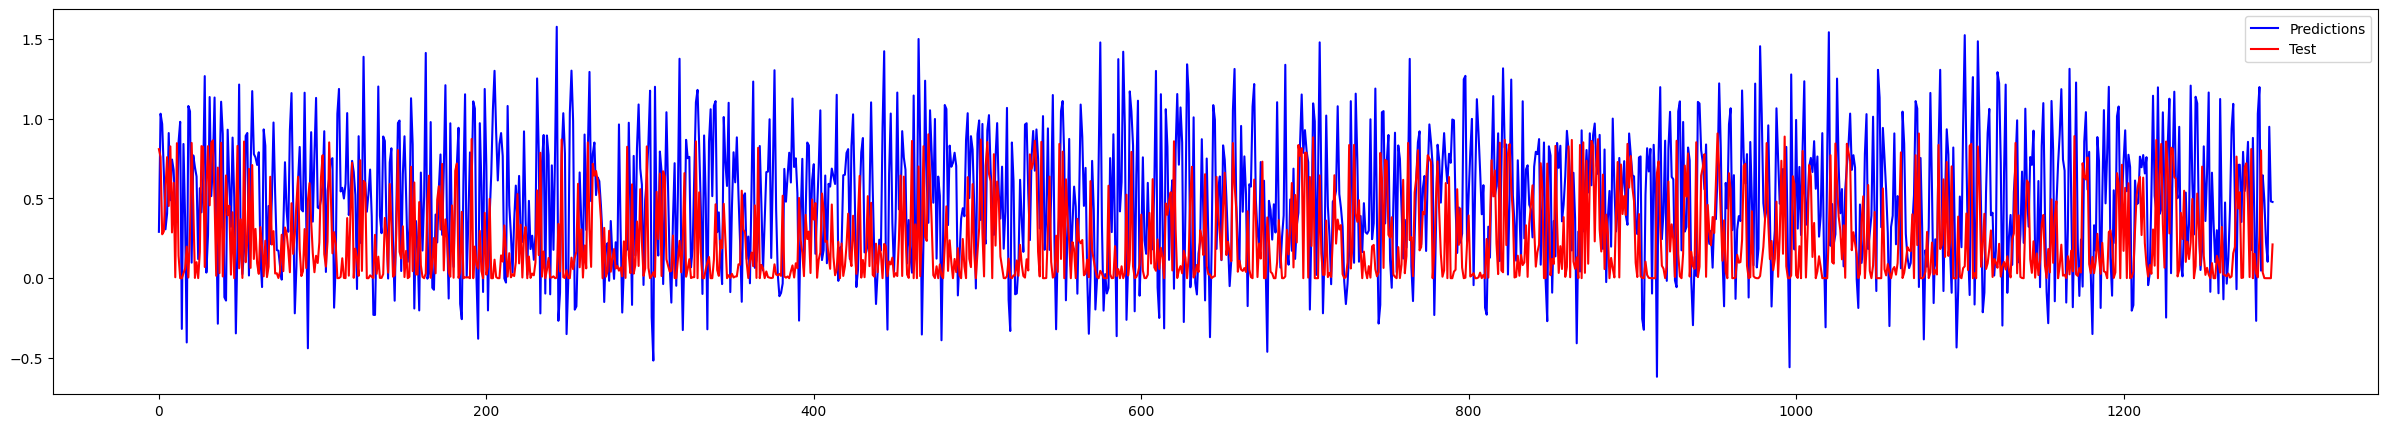

In [79]:
reconstr = np.column_stack([predictions, predictions2])
print(reconstr.shape)

inverse_predictions = np.fft.irfft(reconstr)
plt.figure(figsize=(30, 5))
plt.plot(inverse_predictions[:, 0], 'b')
plt.plot(QBERS[train_size:, 0], 'r')
plt.legend(['Predictions', 'Test'])

In [77]:
plt.figure(figsize=(30, 5))
plt.plot(QBERS[train_size:, 0] - inverse_predictions[train_size:, 0], 'r')
plt.legend(['Predictions', 'Test'])

ValueError: operands could not be broadcast together with shapes (1292,) (0,) 

<Figure size 3000x500 with 0 Axes>